In [50]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Basic libraries
import os
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import plot

# Time series analysis libraries
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess

# Miscellaneous
from numpy.random import normal, seed
from scipy.stats import norm
import math
from sklearn.metrics import mean_squared_error




In [51]:
google = pd.read_csv('/GOOGL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
google.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


In [52]:
humidity = pd.read_csv('/humidity.csv', index_col='datetime', parse_dates=['datetime'])
humidity.tail()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2017-11-29 20:00:00,NaN,81.0,NaN,93.0,24.0,72.0,18.0,68.0,37.0,18.0,...,27.0,NaN,64.0,37.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 21:00:00,NaN,71.0,NaN,87.0,21.0,72.0,18.0,73.0,34.0,12.0,...,29.0,NaN,59.0,74.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 22:00:00,NaN,71.0,NaN,93.0,23.0,68.0,17.0,60.0,32.0,15.0,...,31.0,NaN,66.0,74.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 23:00:00,NaN,71.0,NaN,87.0,14.0,63.0,17.0,33.0,30.0,28.0,...,26.0,NaN,58.0,56.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-30 00:00:00,NaN,76.0,NaN,75.0,56.0,72.0,17.0,23.0,34.0,31.0,...,32.0,NaN,58.0,56.0,NaN,NaN,NaN,NaN,NaN,NaN


##Cleaning and preparing data:


The Google stocks dataset is complete, with no missing values. However, the **humidity** dataset does exhibit some gaps. To address this, we've employed the **fillna()** method with the **ffill** parameter, which propagates the last valid observation forward, ensuring continuity in the dataset.

In [53]:
humidity = humidity.iloc[1:]
humidity = humidity.fillna(method='ffill')
humidity.head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01 13:00:00,76.0,81.0,88.0,81.0,88.0,82.0,22.0,23.0,50.0,62.0,...,71.0,58.0,93.0,68.0,50.0,63.0,22.0,51.0,51.0,50.0
2012-10-01 14:00:00,76.0,80.0,87.0,80.0,88.0,81.0,21.0,23.0,49.0,62.0,...,70.0,57.0,91.0,68.0,51.0,62.0,22.0,51.0,51.0,50.0
2012-10-01 15:00:00,76.0,80.0,86.0,80.0,88.0,81.0,21.0,23.0,49.0,62.0,...,70.0,57.0,87.0,68.0,51.0,62.0,22.0,51.0,51.0,50.0
2012-10-01 16:00:00,77.0,80.0,85.0,79.0,88.0,81.0,21.0,23.0,49.0,62.0,...,69.0,57.0,84.0,68.0,52.0,62.0,22.0,51.0,51.0,50.0
2012-10-01 17:00:00,78.0,79.0,84.0,79.0,88.0,80.0,21.0,24.0,49.0,63.0,...,69.0,57.0,80.0,68.0,54.0,62.0,23.0,51.0,51.0,50.0


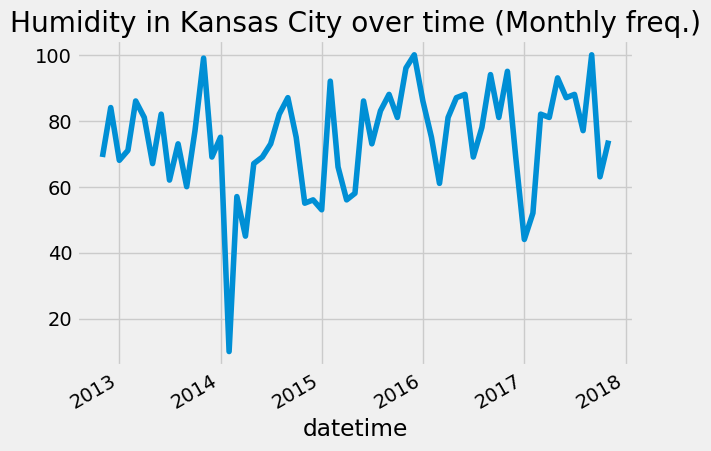

In [54]:
humidity["Kansas City"].asfreq('M').plot()
plt.title('Humidity in Kansas City over time (Monthly freq.)')
plt.show()

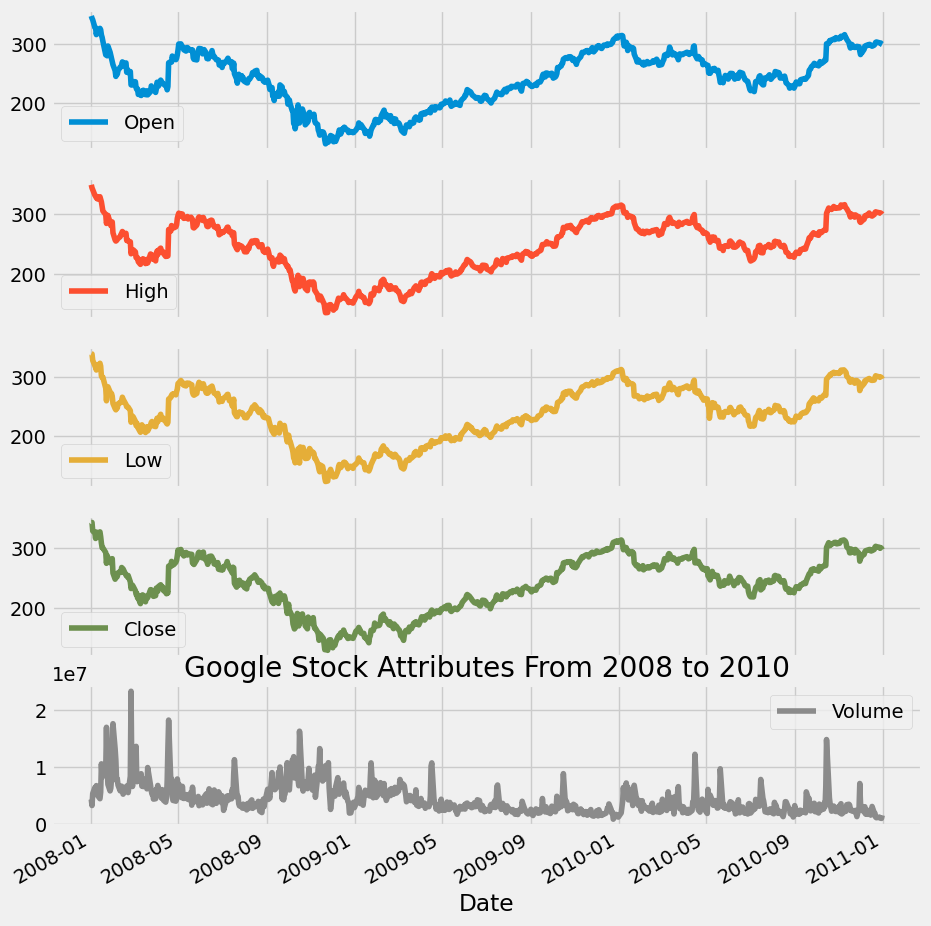

In [55]:
google['2008':'2010'].plot(subplots=True, figsize=(10,12))
plt.title('Google Stock Attributes From 2008 to 2010')
plt.savefig('stocks.png')
plt.show()

In [56]:
# Creating a Timestamp
timestamp = pd.Timestamp(2017, 1, 1, 12)
timestamp

Timestamp('2017-01-01 12:00:00')

In [57]:
period = pd.Period('2017-01-01')
period

Period('2017-01-01', 'D')

In [58]:
# Checking if the given timestamp exists in the given period
period.start_time < timestamp < period.end_time


True

In [59]:
# Converting timestamp to period
new_period = timestamp.to_period(freq='H')
new_period

Period('2017-01-01 12:00', 'H')

In [60]:
# Converting period to timestamp
new_timestamp = period.to_timestamp(freq='H', how='start')
new_timestamp

Timestamp('2017-01-01 00:00:00')

In [61]:
# Creating a datetimeindex with daily frequency
dr1 = pd.date_range(start='1/1/18', end='1/9/18')
dr1

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09'],
              dtype='datetime64[ns]', freq='D')

In [62]:
# Creating a datetimeindex with monthly frequency
dr2 = pd.date_range(start='1/1/18', end='1/1/19', freq='M')
dr2

DatetimeIndex(['2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31'],
              dtype='datetime64[ns]', freq='M')

In [63]:
# Creating a datetimeindex without specifying start date and using periods
dr3 = pd.date_range(end='1/4/2014', periods=8)
dr3

DatetimeIndex(['2013-12-28', '2013-12-29', '2013-12-30', '2013-12-31',
               '2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04'],
              dtype='datetime64[ns]', freq='D')

In [64]:
# Creating a datetimeindex specifying start date , end date and periods
dr4 = pd.date_range(start='2013-04-24', end='2014-11-27', periods=3)
dr4

DatetimeIndex(['2013-04-24', '2014-02-09', '2014-11-27'], dtype='datetime64[ns]', freq=None)

In [65]:
df = pd.DataFrame({'year': [2015, 2016], 'month': [2, 3], 'day': [4, 5]})
df

,year,month,day
0,2015,2,4
1,2016,3,5


In [66]:
df = pd.to_datetime(df)
df

0   2015-02-04
1   2016-03-05
dtype: datetime64[ns]

In [67]:
df = pd.to_datetime('01-01-2017')
df

Timestamp('2017-01-01 00:00:00')

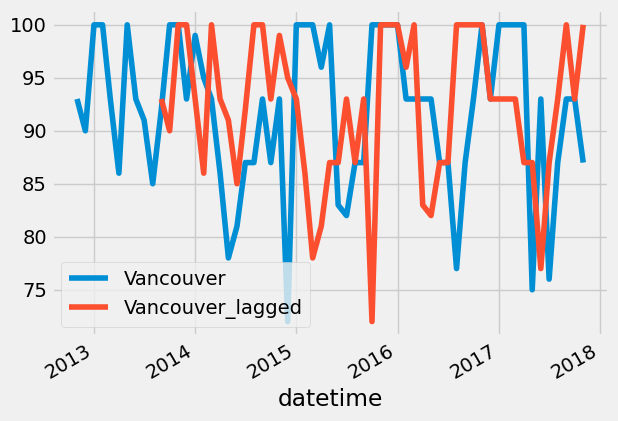

In [68]:
#Shifting and lags to compare time series with a past of itself.
humidity["Vancouver"].asfreq('M').plot(legend=True)
shifted = humidity["Vancouver"].asfreq('M').shift(10).plot(legend=True)
shifted.legend(['Vancouver','Vancouver_lagged'])
plt.show()

In [69]:
#Resampling
pressure = pd.read_csv('/pressure.csv', index_col='datetime', parse_dates=['datetime'])
pressure.tail()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2017-11-29 20:00:00,NaN,1031.0,NaN,1030.0,1016.0,1017.0,1021.0,1018.0,1025.0,1016.0,...,1021.0,NaN,1021.0,1017.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 21:00:00,NaN,1030.0,NaN,1030.0,1016.0,1017.0,1020.0,1018.0,1024.0,1018.0,...,1021.0,NaN,1023.0,1019.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 22:00:00,NaN,1030.0,NaN,1029.0,1015.0,1016.0,1020.0,1017.0,1024.0,1018.0,...,1022.0,NaN,1024.0,1019.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 23:00:00,NaN,1029.0,NaN,1028.0,1016.0,1016.0,1020.0,1016.0,1024.0,1020.0,...,1023.0,NaN,1026.0,1022.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-30 00:00:00,NaN,1029.0,NaN,1028.0,1015.0,1017.0,1019.0,1016.0,1024.0,1021.0,...,1024.0,NaN,1027.0,1023.0,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
pressure = pressure.iloc[1:]
pressure = pressure.fillna(method='ffill')
pressure.tail()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2017-11-29 20:00:00,1021.0,1031.0,1013.0,1030.0,1016.0,1017.0,1021.0,1018.0,1025.0,1016.0,...,1021.0,1020.0,1021.0,1017.0,984.0,1011.0,968.0,1023.0,1023.0,1011.0
2017-11-29 21:00:00,1021.0,1030.0,1013.0,1030.0,1016.0,1017.0,1020.0,1018.0,1024.0,1018.0,...,1021.0,1020.0,1023.0,1019.0,984.0,1011.0,968.0,1023.0,1023.0,1011.0
2017-11-29 22:00:00,1021.0,1030.0,1013.0,1029.0,1015.0,1016.0,1020.0,1017.0,1024.0,1018.0,...,1022.0,1020.0,1024.0,1019.0,984.0,1011.0,968.0,1023.0,1023.0,1011.0
2017-11-29 23:00:00,1021.0,1029.0,1013.0,1028.0,1016.0,1016.0,1020.0,1016.0,1024.0,1020.0,...,1023.0,1020.0,1026.0,1022.0,984.0,1011.0,968.0,1023.0,1023.0,1011.0
2017-11-30 00:00:00,1021.0,1029.0,1013.0,1028.0,1015.0,1017.0,1019.0,1016.0,1024.0,1021.0,...,1024.0,1020.0,1027.0,1023.0,984.0,1011.0,968.0,1023.0,1023.0,1011.0


In [71]:
pressure = pressure.fillna(method='bfill')
pressure.head()


,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01 13:00:00,807.0,1024.0,1009.0,1027.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,1001.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
2012-10-01 14:00:00,807.0,1024.0,1009.0,1027.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,986.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
2012-10-01 15:00:00,807.0,1024.0,1009.0,1028.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,945.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
2012-10-01 16:00:00,807.0,1024.0,1009.0,1028.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,904.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
2012-10-01 17:00:00,807.0,1024.0,1009.0,1029.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,863.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0


In [72]:
# Using bfill to propogate next valid observation to fill gaps.
pressure.shape

(45252, 36)

In [73]:
# Downsampling from hourly to 3 day frequency aggregated using mean
pressure = pressure.resample('3D').mean()
pressure.head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01,931.627119,1022.644068,1010.881356,1031.271186,1011.627119,1011.966102,1016.322034,1012.084746,1022.542373,1024.118644,...,1014.152542,1013.423729,937.627119,1013.677966,985.050847,1012.949153,1011.796610,1013.000000,1013.000000,990.525424
2012-10-04,1019.083333,1023.041667,1014.694444,1028.305556,1015.555556,1016.277778,1013.194444,1014.097222,1019.972222,1020.666667,...,1018.097222,1017.680556,1017.180556,1019.805556,984.930556,1013.083333,1012.611111,1013.000000,1013.000000,990.083333
2012-10-07,1013.930556,1017.444444,1016.597222,1018.736111,1013.416667,1014.222222,1012.888889,1011.861111,1005.833333,1020.458333,...,1017.958333,1016.750000,1014.152778,1016.305556,982.972222,1013.027778,1007.555556,1013.000000,1013.000000,989.833333
2012-10-10,1015.000000,1015.430556,1014.833333,1018.416667,1010.694444,1014.013889,1000.166667,1005.611111,986.000000,984.486111,...,1018.694444,1017.916667,1016.166667,1017.319444,979.763889,1006.527778,998.763889,1012.333333,1012.333333,987.888889
2012-10-13,1008.152778,1018.111111,1021.069444,1015.930556,1017.277778,1018.375000,1015.666667,1015.500000,1013.625000,1010.444444,...,1025.055556,1024.388889,1020.805556,1023.736111,984.527778,1013.027778,1007.194444,1013.000000,1013.000000,990.430556


In [74]:
# Shape after resampling(downsampling)
pressure.shape


(629, 36)

In [75]:
# Upsampling from 3 day frequency to daily frequency
pressure = pressure.resample('D').pad()
pressure.head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01,931.627119,1022.644068,1010.881356,1031.271186,1011.627119,1011.966102,1016.322034,1012.084746,1022.542373,1024.118644,...,1014.152542,1013.423729,937.627119,1013.677966,985.050847,1012.949153,1011.796610,1013.0,1013.0,990.525424
2012-10-02,931.627119,1022.644068,1010.881356,1031.271186,1011.627119,1011.966102,1016.322034,1012.084746,1022.542373,1024.118644,...,1014.152542,1013.423729,937.627119,1013.677966,985.050847,1012.949153,1011.796610,1013.0,1013.0,990.525424
2012-10-03,931.627119,1022.644068,1010.881356,1031.271186,1011.627119,1011.966102,1016.322034,1012.084746,1022.542373,1024.118644,...,1014.152542,1013.423729,937.627119,1013.677966,985.050847,1012.949153,1011.796610,1013.0,1013.0,990.525424
2012-10-04,1019.083333,1023.041667,1014.694444,1028.305556,1015.555556,1016.277778,1013.194444,1014.097222,1019.972222,1020.666667,...,1018.097222,1017.680556,1017.180556,1019.805556,984.930556,1013.083333,1012.611111,1013.0,1013.0,990.083333
2012-10-05,1019.083333,1023.041667,1014.694444,1028.305556,1015.555556,1016.277778,1013.194444,1014.097222,1019.972222,1020.666667,...,1018.097222,1017.680556,1017.180556,1019.805556,984.930556,1013.083333,1012.611111,1013.0,1013.0,990.083333


In [76]:
# Shape after resampling(upsampling)
pressure.shape

(1885, 36)

##Finance and Statistics

<Axes: xlabel='Date'>

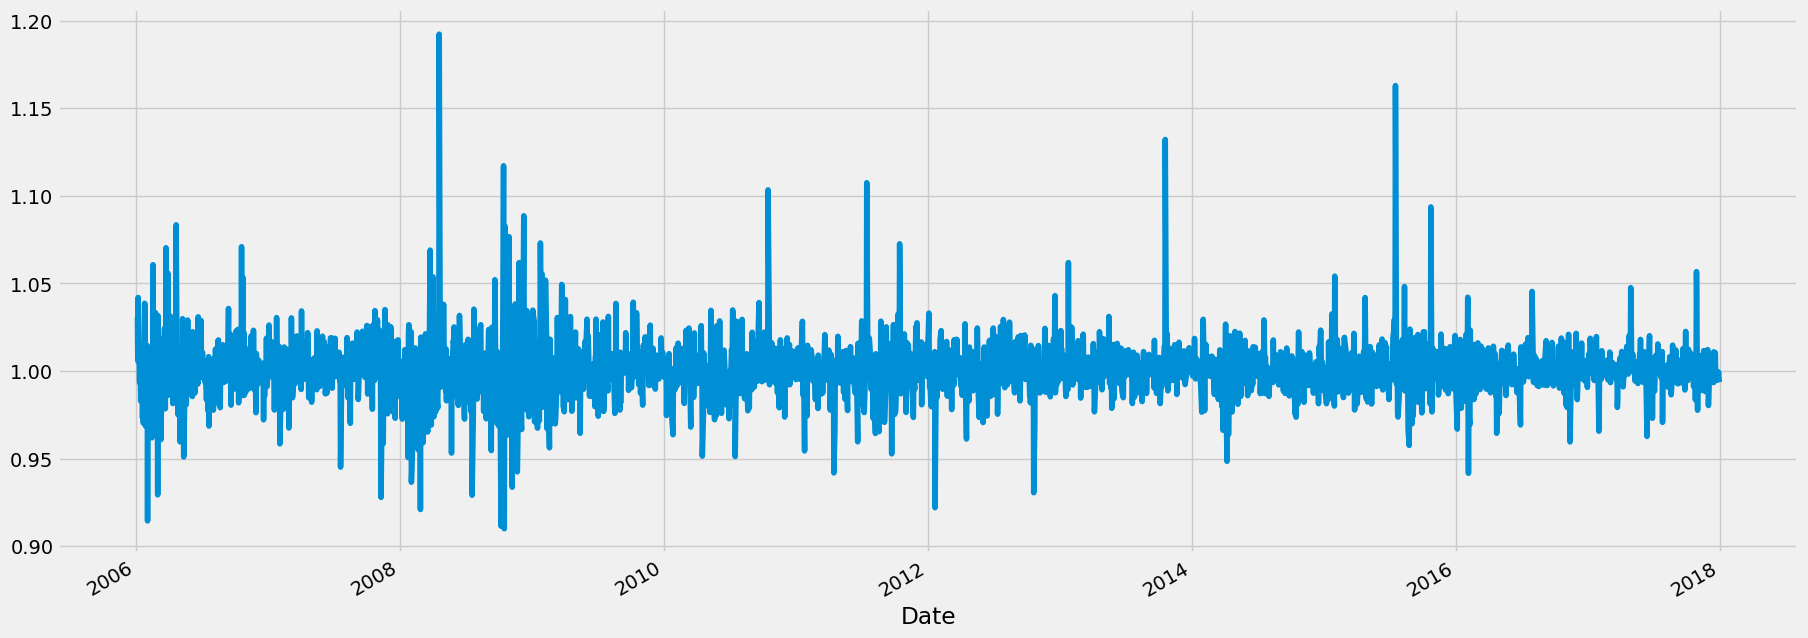

In [77]:
google['Change'] = google.High.div(google.High.shift())
google['Change'].plot(figsize=(20,8))

<Axes: xlabel='Date'>

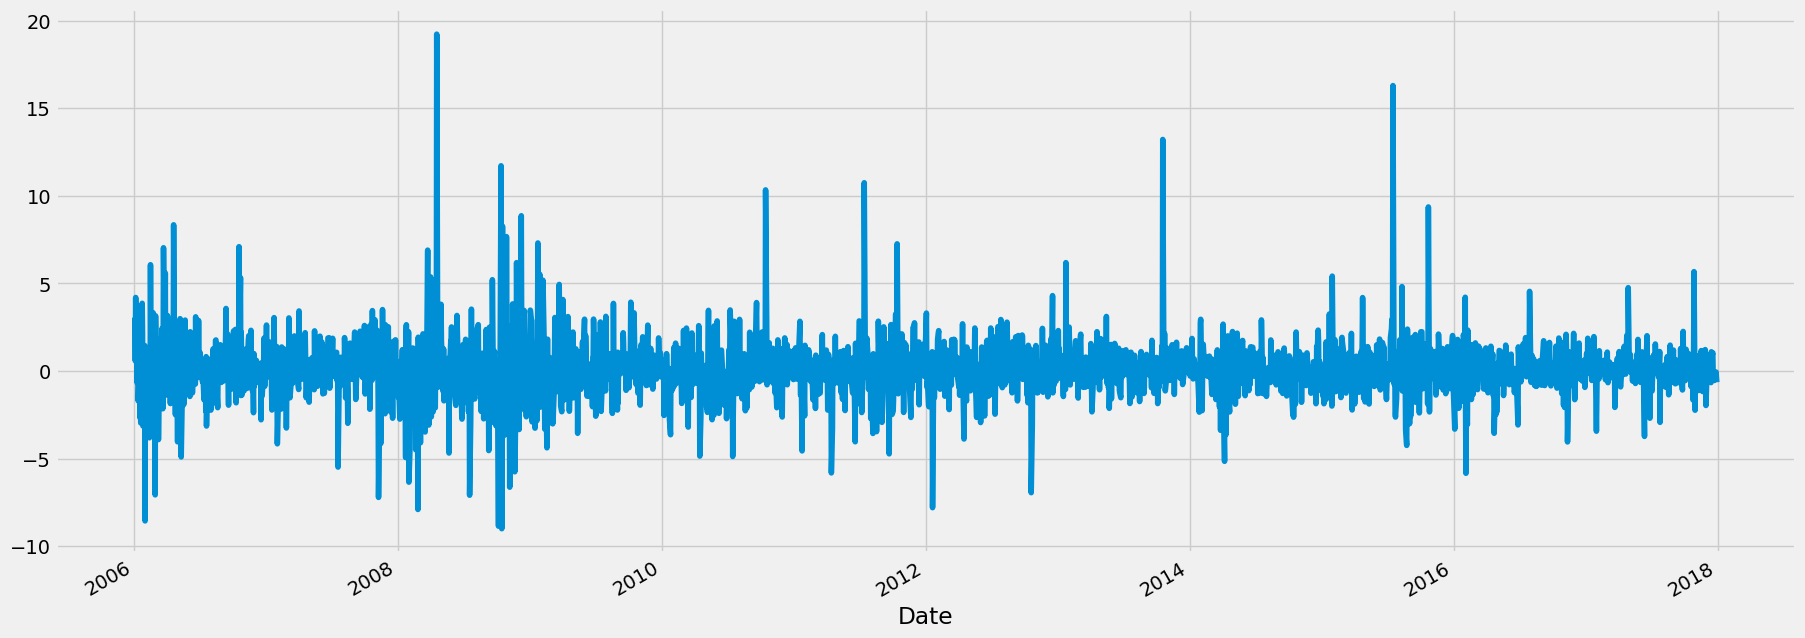

In [78]:
#Stock returns
google['Return'] = google.Change.sub(1).mul(100)
google['Return'].plot(figsize=(20,8))

<Axes: xlabel='Date'>

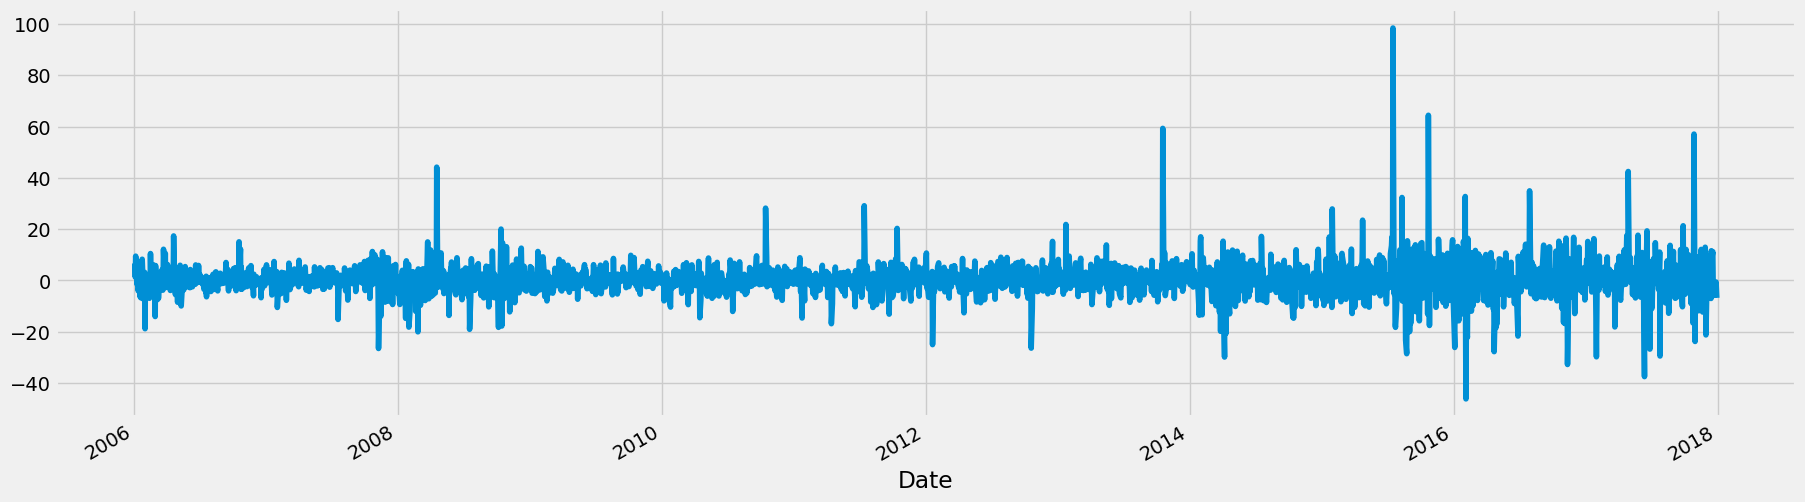

In [79]:
google.High.diff().plot(figsize=(20,6))

In [80]:
# Compating two or more time series
hd = pd.read_csv('/HD_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])

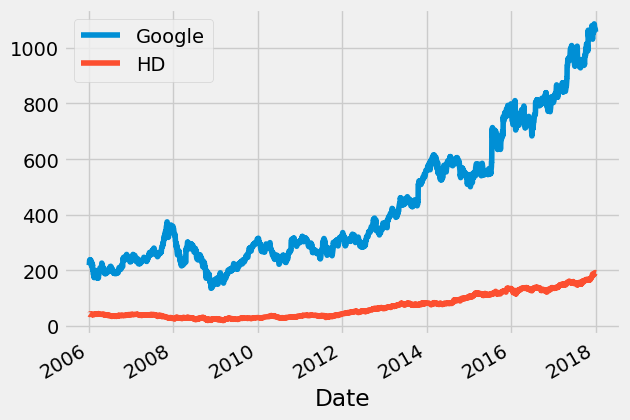

In [81]:
# before normalization
google.High.plot()
hd.High.plot()
plt.legend(['Google','HD'])
plt.show()

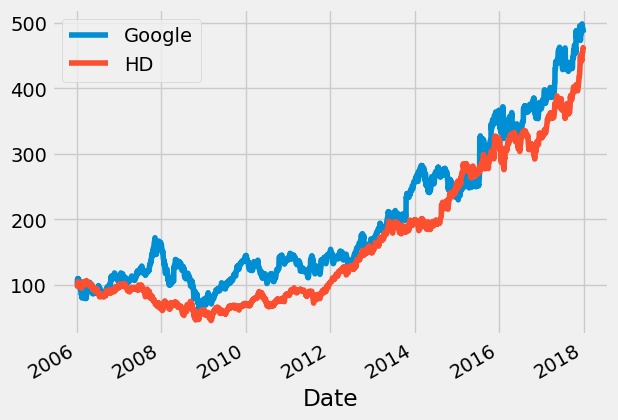

In [82]:
# Normalizing and comparison
# Both stocks start from 100
normalized_google = google.High.div(google.High.iloc[0]).mul(100)
normalized_hd = hd.High.div(hd.High.iloc[0]).mul(100)
normalized_google.plot()
normalized_hd.plot()
plt.legend(['Google','HD'])
plt.show()

##Insights:
It is evident from the data that Google consistently outperforms HD over the analyzed period.

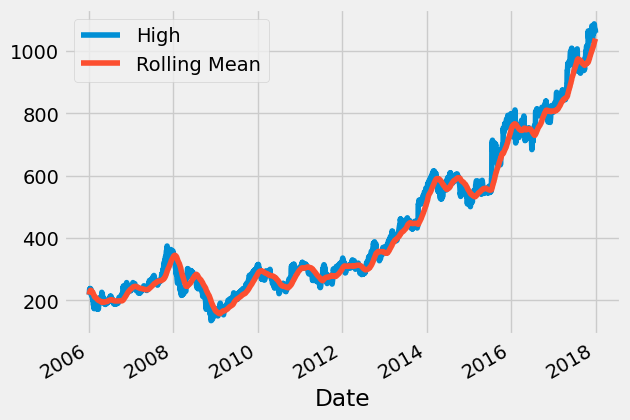

In [83]:
#Window functions to identify sub periods, calculates sub-metrics of sub-periods.
# Rolling window functions
rolling_google = google.High.rolling('90D').mean()
google.High.plot()
rolling_google.plot()
plt.legend(['High','Rolling Mean'])

# Plotting a rolling mean of 90 day window with original High attribute of google stocks
plt.show()

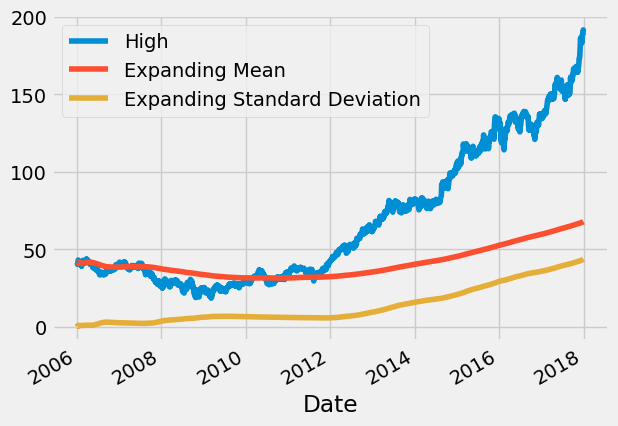

In [84]:
# Expanding window functions
hd_mean = hd.High.expanding().mean()
hd_std = hd.High.expanding().std()
hd.High.plot()
hd_mean.plot()
hd_std.plot()
plt.legend(['High','Expanding Mean','Expanding Standard Deviation'])
plt.show()

##Autocorrelation:
The autocorrelation function (ACF) measures how a series is correlated with itself at different lags.


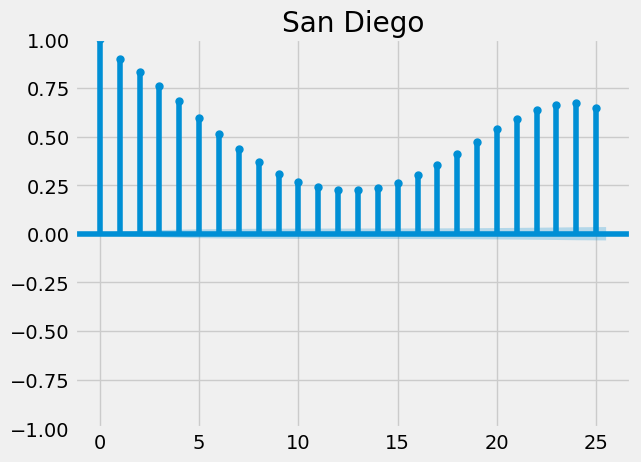

In [89]:
# Autocorrelation of humidity of San Diego
plot_acf(humidity["San Diego"],lags=25,title="San Diego")
plt.show()

## Partial Autocorrelation:
 The partial autocorrelation function can be interpreted as a regression of the series against its past lags. The terms can be interpreted the same way as a standard linear regression, that is the contribution of a change in that particular lag while holding others constant.

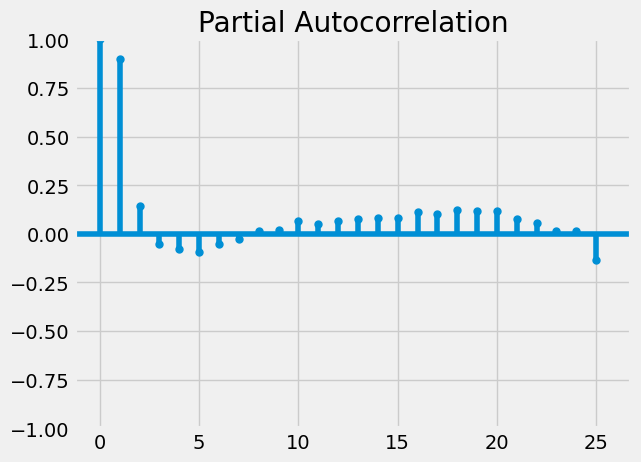

In [91]:
# Partial Autocorrelation of humidity of San Diego
plot_pacf(humidity["San Diego"],lags=25)
plt.show()

**Insights:**

While the results demonstrate statistical significance, the partial autocorrelation observed beyond the initial two lags remains notably minimal.


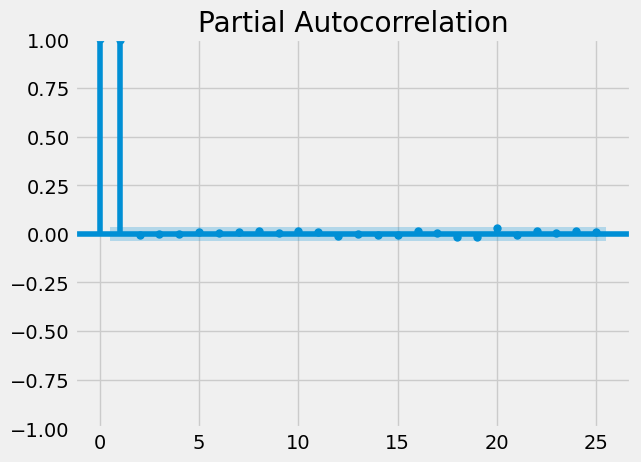

In [92]:
# Partial Autocorrelation of closing price of hd stocks
plot_pacf(hd["Close"],lags=25)
plt.show()

**Insights:**

Here, only the 0th lag is statistically significant.

##Time series decomposition and random walks:

<Axes: xlabel='Date'>

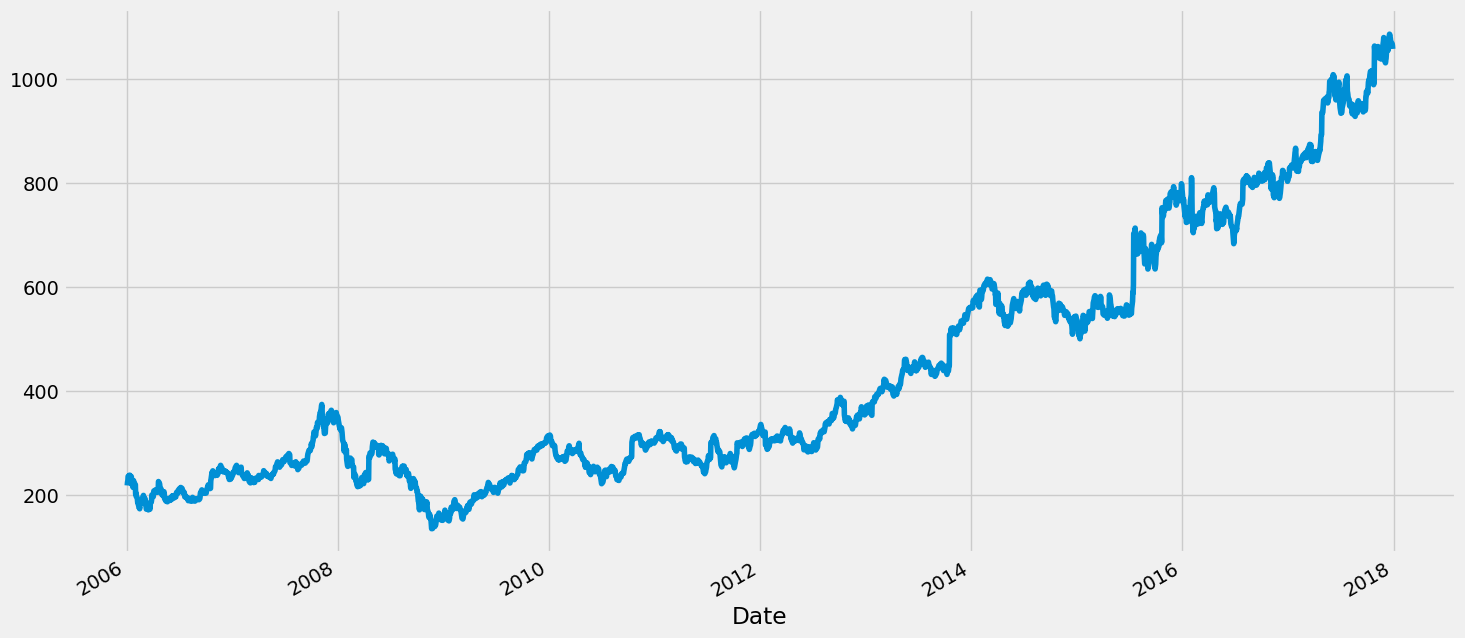

In [93]:
#google stocks high
google["High"].plot(figsize=(16,8))

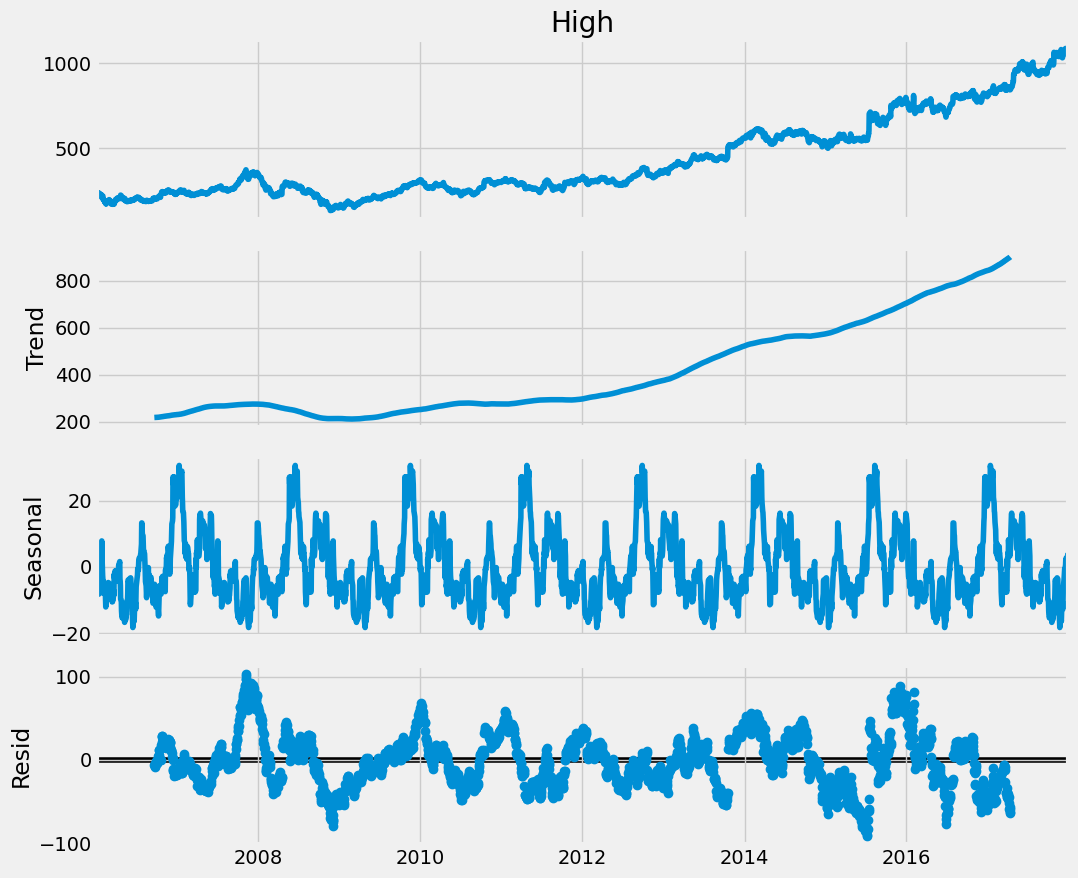

In [98]:
#decompositioning it
rcParams['figure.figsize'] = 11, 9
decomposed_google_volume = sm.tsa.seasonal_decompose(google["High"], period=360)
figure = decomposed_google_volume.plot()
plt.show()

### **Insights**
Through the decomposition of the time series, we discern three integral components: Trend, Seasonality, and Residuals.

**Trend:** The data exhibits a discernible upward trajectory, suggesting a consistent increase over time.

**Seasonality:** There's a consistent cyclical pattern, indicating predictable fluctuations at regular intervals.

**Residuals:** The residuals, which encompass the noise in the dataset, appear non-uniform. This suggests the presence of anomalies, outliers, or potential missing values that could require further investigation.

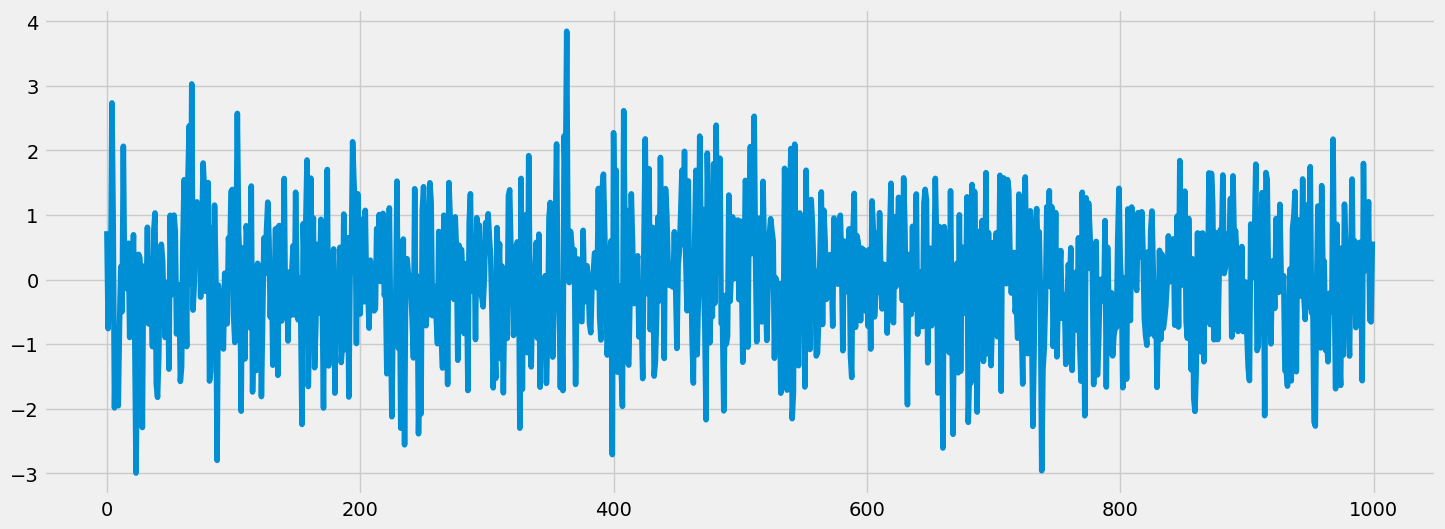

In [99]:
#plotting white noise

rcParams['figure.figsize'] = 16, 6
white_noise = np.random.normal(loc=0, scale=1, size= 1000)

plt.plot(white_noise)

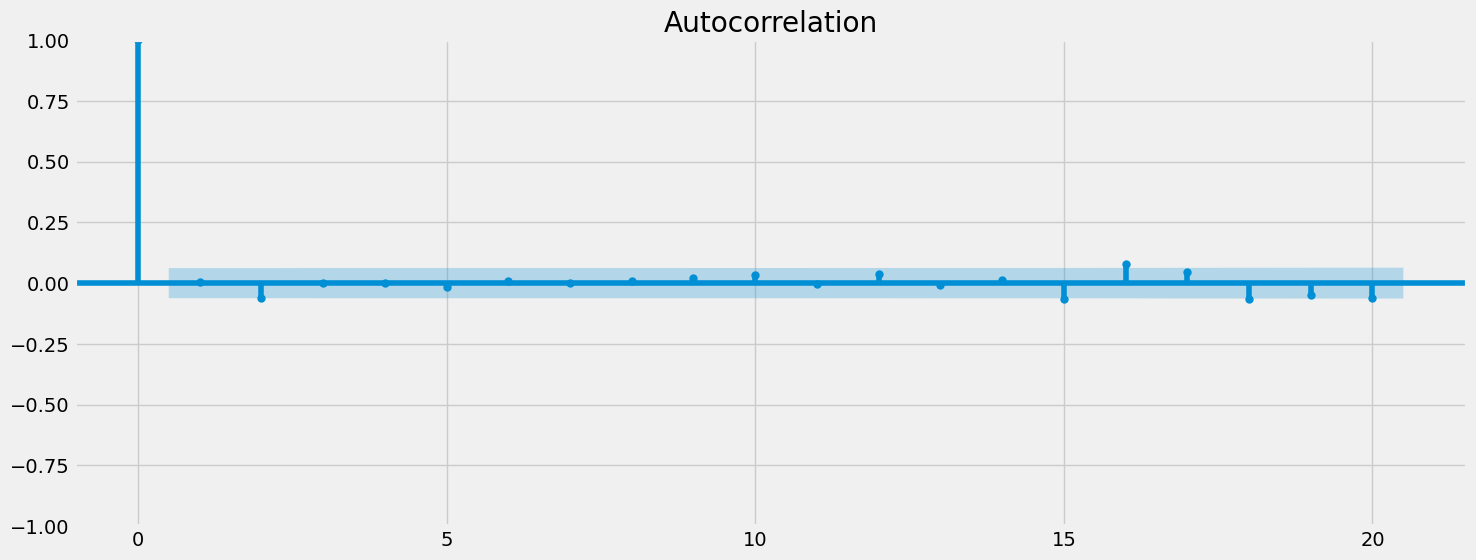

In [101]:
#autocorrelation of white noise
plot_acf(white_noise, lags=20)
plt.show()

Upon examination of the lags, it's evident that they are statistically insignificant. This is underscored by the fact that they are encompassed within the confidence interval, denoted by the shaded region.


##Random Walk:
A random walk is a foundational concept in stochastic processes, representing a sequence of steps wherein each step is determined by a random mechanism or a predefined probabilistic setting. In its simplest form, particularly on an integer space, think of it as a person walking along a line where each step they take—forward or backward—is entirely random. Over time, this "walk" forms a path that is governed by chance, and the sequence of steps is often of interest in various scientific fields, from finance to physics.



---


#####**Augmented Dickey-Fuller test:**
The Augmented Dickey–Fuller (ADF) test is a statistical procedure used to determine the presence of a unit root in a time series. The unit root test examines whether a time series is non-stationary, which implies a tendency for the series to exhibit a trend or drift over time. The "augmented" aspect of the ADF test includes lagged terms of the time series in the test equation to account for potential autocorrelations in the data. In essence, while the basic Dickey-Fuller test considers a simpler autoregressive model, the ADF test offers a more generalized approach, making it more robust for analyzing more complex time series structures.

In [102]:
adf = adfuller(hd["Volume"])
print("p-value of hd: {}".format(float(adf[1])))
adf = adfuller(google["Volume"])
print("p-value of google: {}".format(float(adf[1])))

p-value of hd: 0.033022970696604335
p-value of google: 6.510719605768349e-07


For the stock **"hd"**, the p-value obtained is approximately 0.033, which is below the conventional significance threshold of 0.05.
This suggests that we can reject the null hypothesis, implying that the series is not a random walk and is likely stationary.

Conversely, for the **"google"** stock, the p-value is approximately 6.51 × 10^−7
, which is significantly smaller than 0.05.
Thus, we can confidently reject the null hypothesis for "google" as well, indicating that this series too is not a random walk and exhibits stationarity.

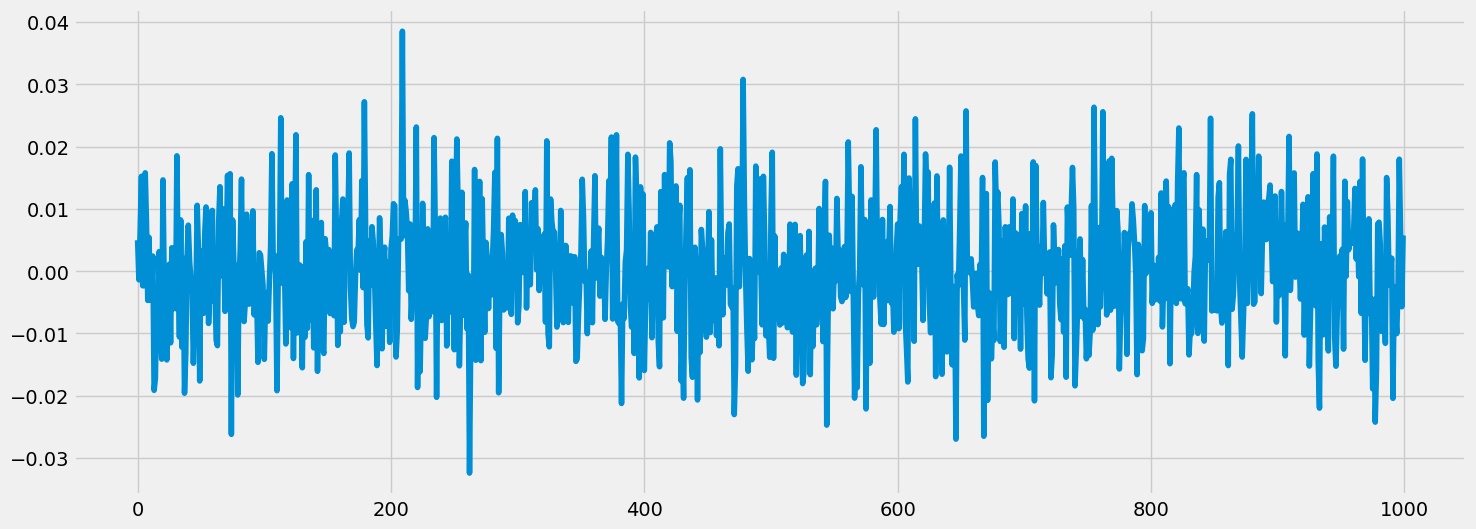

In [103]:
#generating a random walk
seed(42)
rcParams['figure.figsize'] = 16, 6
random_walk = normal(loc=0, scale=0.01, size=1000)
plt.plot(random_walk)
plt.show()

##Stationary:
A time series is deemed stationary when its statistical properties, including mean, variance, and autocorrelation structure, remain consistent and invariant with respect to time. This implies that the fluctuations and patterns observed in the series are consistent over time and do not exhibit seasonality, cyclic behaviors, or other trends.

**Stationarity** is a foundational assumption for many time series forecasting models because the consistent statistical properties ensure that the model remains valid for future predictions.

**Non-stationary** time series can often be transformed into stationary ones through techniques such as differencing, decomposition, or detrending.


<Axes: xlabel='Date'>

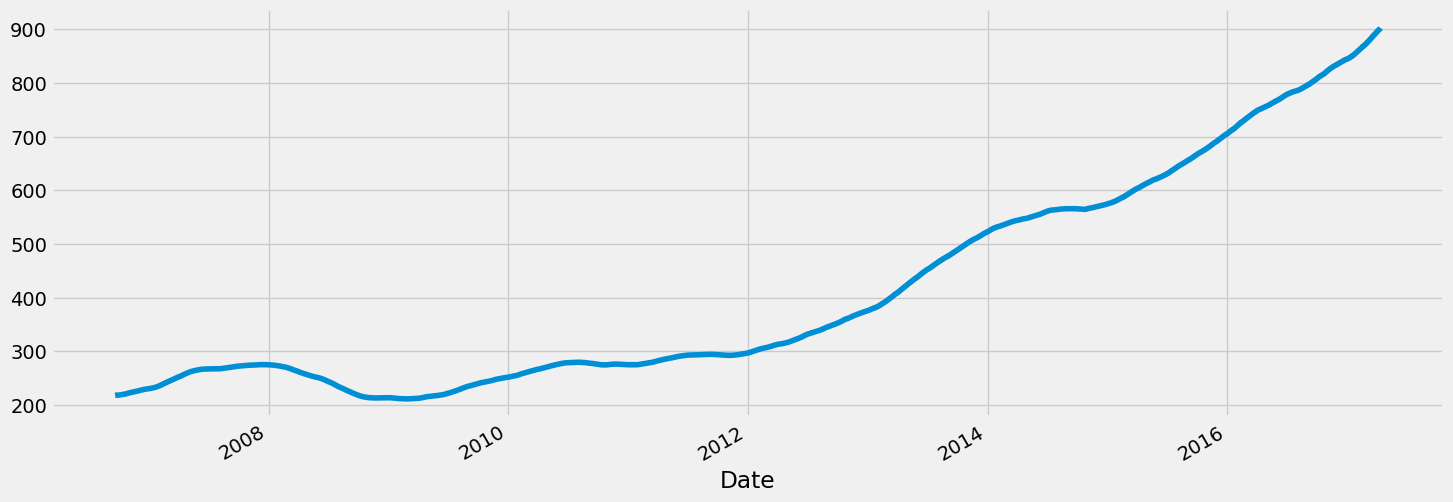

In [119]:
decomposed_google_volume.trend.plot()

<Axes: xlabel='Date'>

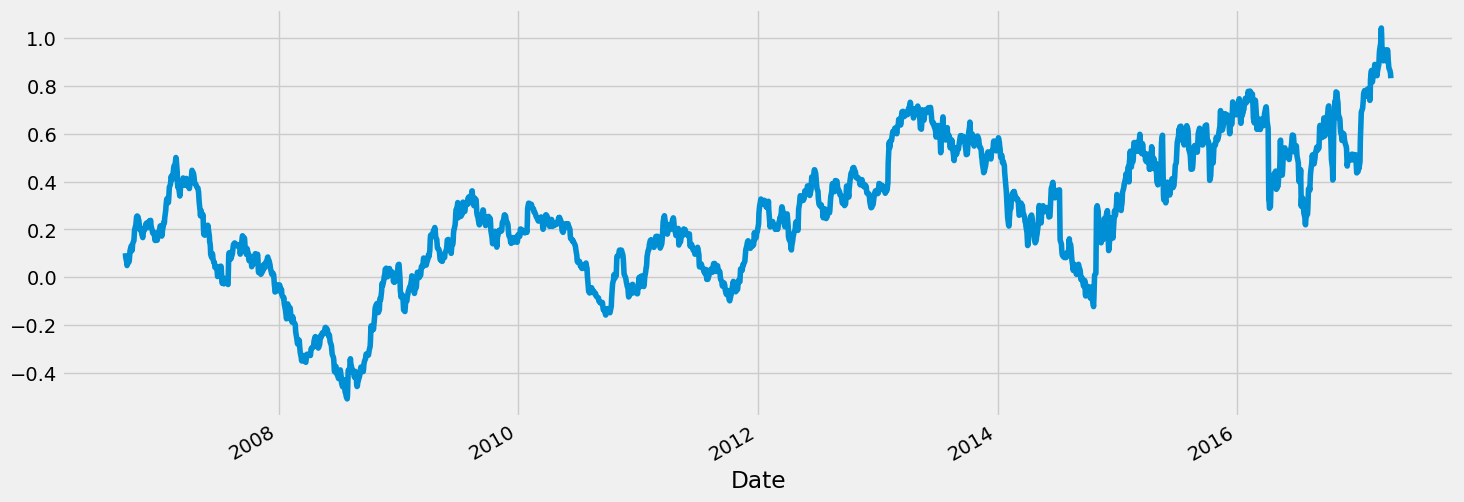

In [120]:
decomposed_google_volume.trend.diff().plot()

###**Modeling using statstools**
An Autoregressive (AR) model represents a specific class of random processes utilized to capture and describe time-dependent structures in various fields, such as nature, finance, and economics. Central to the AR model is the concept that a given output variable is a linear function of its preceding values, combined with a stochastic error term. In essence, it suggests that the current value of a series is influenced or 'regressed' on its previous observations.

Mathematically, this relationship is expressed as a stochastic difference equation. AR models are particularly valuable in time series analysis because they can uncover temporal structures and dependencies in the data, facilitating more accurate forecasting and insights.

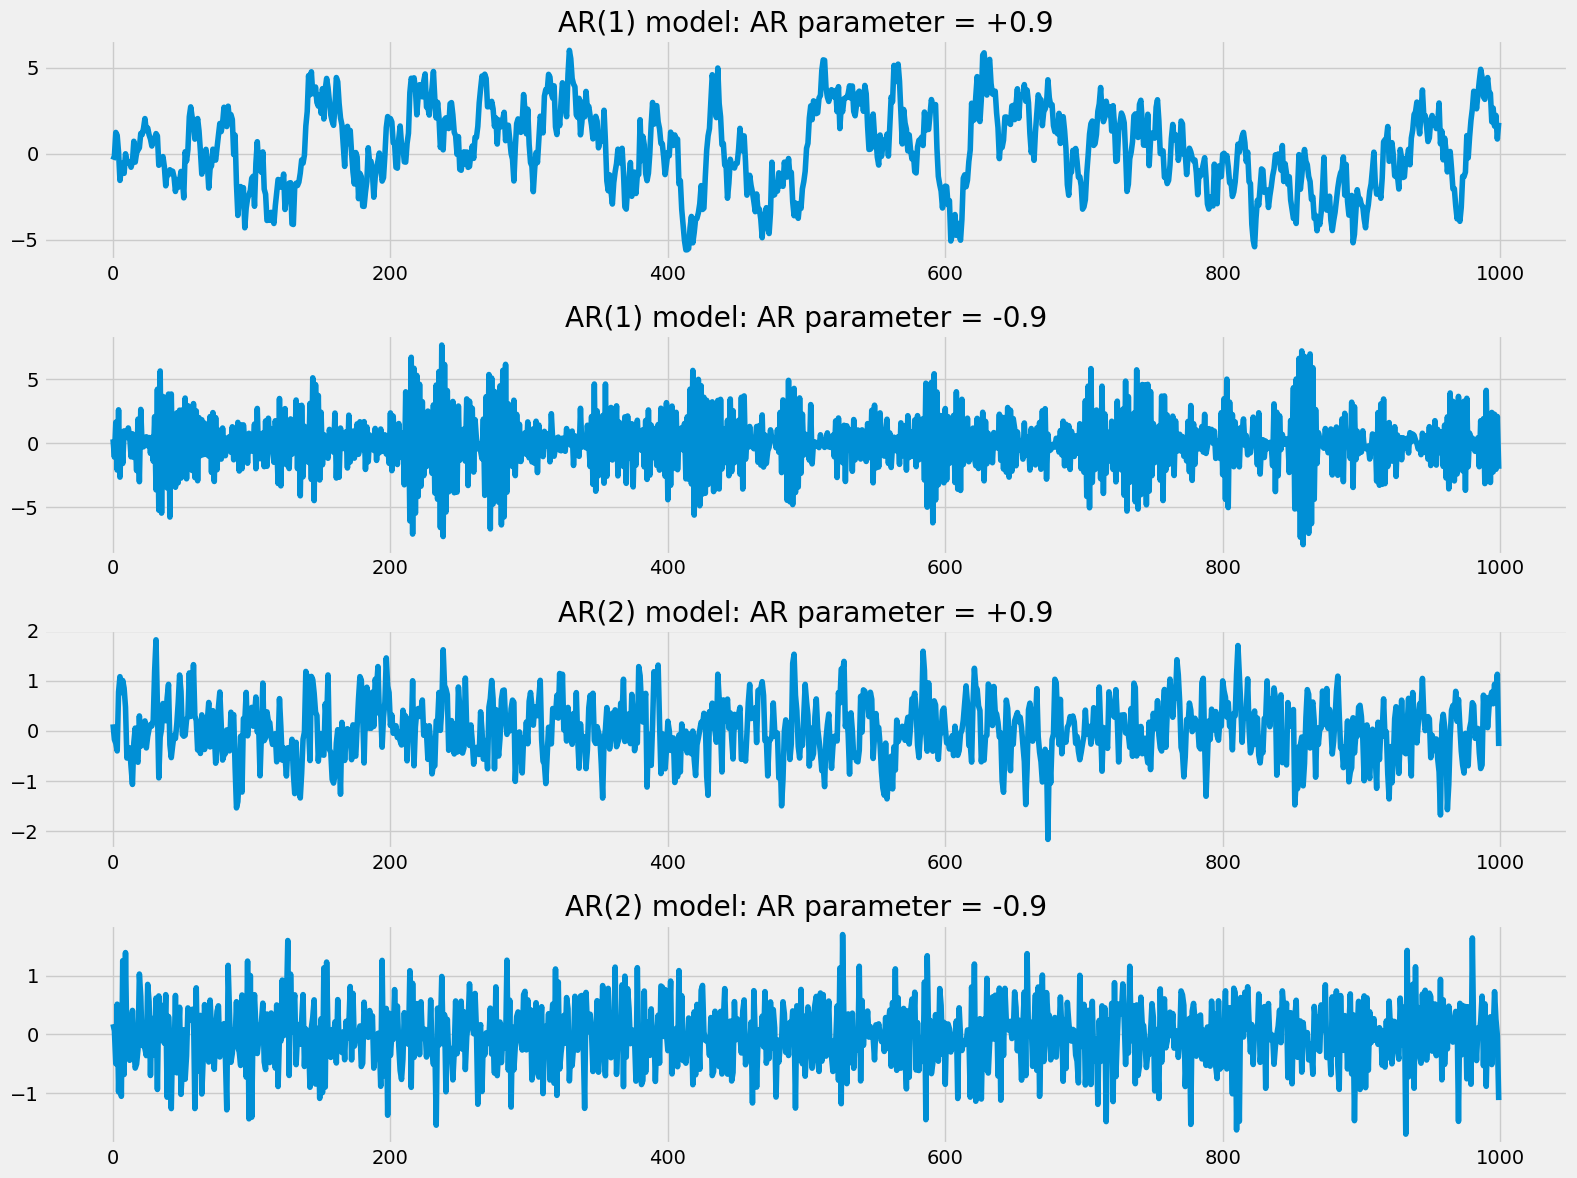

In [136]:
# Configuration
rcParams['figure.figsize'] = 16, 12

# Defining AR and MA parameters
ar_params = [np.array([1, -0.9]), np.array([1, 0.9]), np.array([2, -0.9]), np.array([2, 0.9])]
ma_params = [np.array([1]) for _ in range(4)]
titles = [
    'AR(1) model: AR parameter = +0.9',
    'AR(1) model: AR parameter = -0.9',
    'AR(2) model: AR parameter = +0.9',
    'AR(2) model: AR parameter = -0.9'
]

# Storing simulations for later use
simulations = []

# Generating and plot the simulations
for i, (ar, ma, title) in enumerate(zip(ar_params, ma_params, titles)):
    plt.subplot(4, 1, i+1)

    AR_model = ArmaProcess(ar, ma)
    simulation = AR_model.generate_sample(nsample=1000)
    simulations.append(simulation)

    plt.title(title)
    plt.plot(simulation)

plt.tight_layout()  # Adjusting spacing between subplots for better visibility
plt.show()


**Code explanation:**
- plt.subplot(4, 1, 1) creates a grid for plotting multiple sub-plots. This grid will have 4 rows and 1 column, and the upcoming plot will be placed in the first slot of this grid.
- The AR(1) model is defined with an AR parameter of -0.9 (the signs in the titles seem inverted) and a MA parameter of 1.
- An ARMA process for these parameters is created.
- A sample time series of 1000 data points is generated using this ARMA process.
This simulated time series is plotted with a title.

In [137]:
# Fit an ARIMA(1,0,0) model to the first simulated data
model = ARIMA(simulations[0], order=(1, 0, 0))
result = model.fit()
print(result.summary())
print("μ={} ,ϕ={}".format(result.params[0], result.params[1]))

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1423.988
Date:                Wed, 27 Sep 2023   AIC                           2853.976
Time:                        14:54:21   BIC                           2868.700
Sample:                             0   HQIC                          2859.572
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3083      0.329      0.938      0.348      -0.336       0.952
ar.L1          0.9033      0.015     61.853      0.000       0.875       0.932
sigma2         1.0084      0.046     21.852      0.0

Upon implementing the ARIMA model to our simulated data set, it's noteworthy that the estimated autoregressive (AR) parameter, denoted as ϕ, aligns closely with the predefined AR parameter utilized during the data simulation process, which was set at 0.9. This alignment is indicative of the model's robustness and its adeptness in discerning and adapting to the intrinsic characteristics and dynamics of the data set. From a statistical modeling perspective, such concordance reinforces the validity of our model selection and underscores its capability to reliably capture the underlying autoregressive structure inherent in the data.

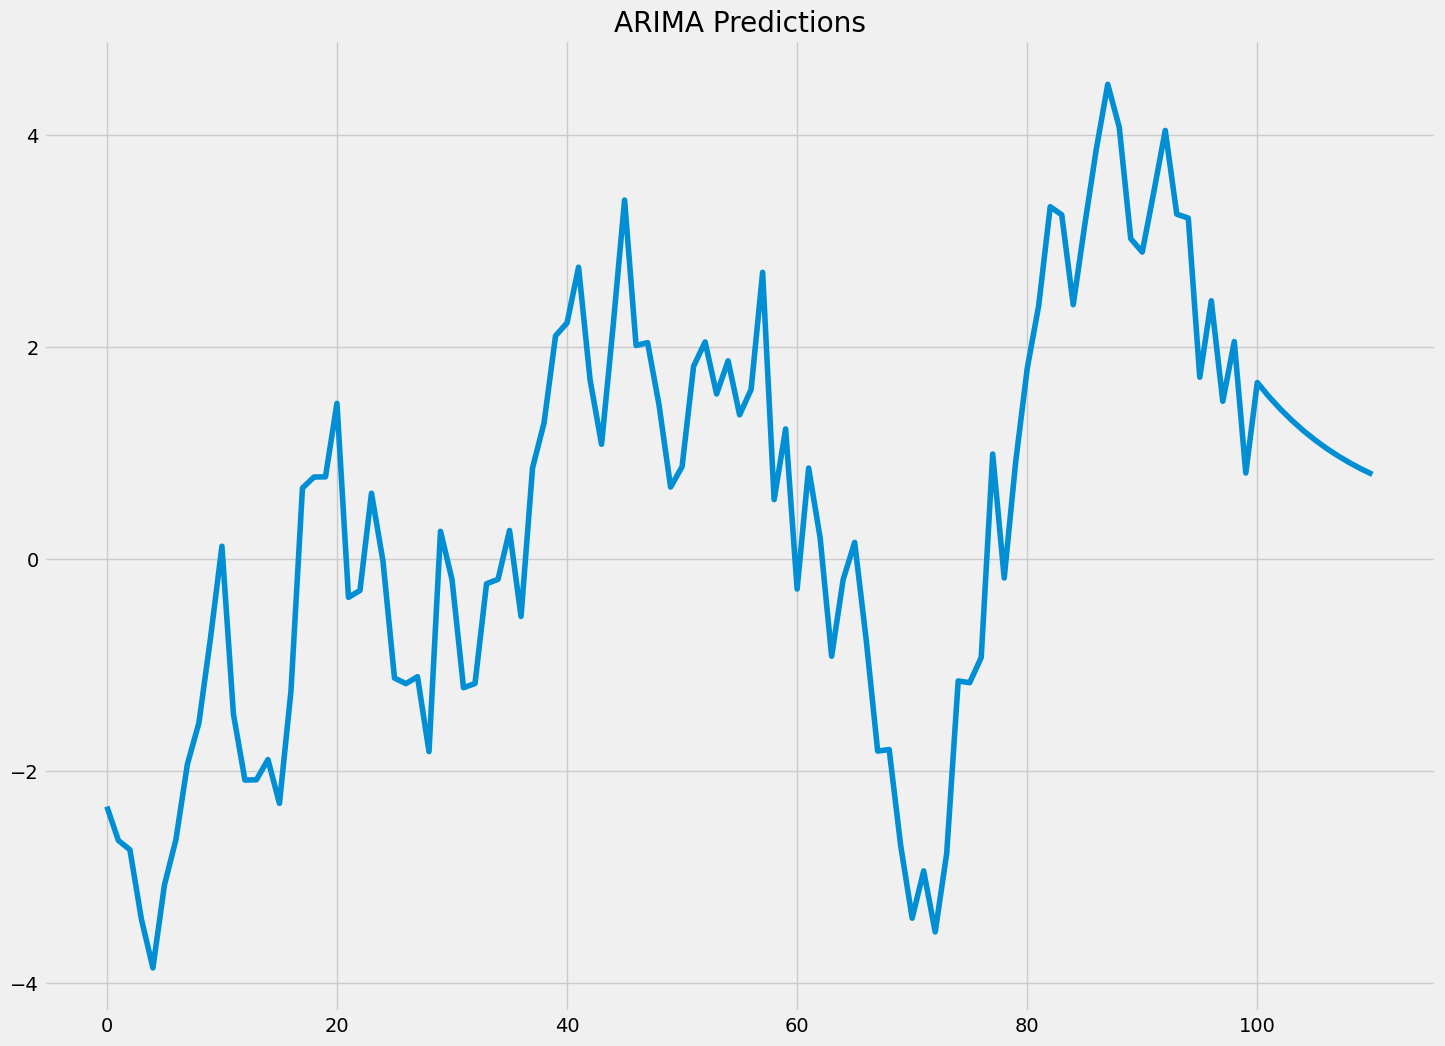

In [138]:
# Predicting Models

predictions = result.predict(start=900, end=1010)
plt.plot(predictions)
plt.title("ARIMA Predictions")
plt.show()

In [141]:
# Predicting values using the ARIMA model
predictions = result.predict(start=900, end=999)
# Computing RMSE
rmse = math.sqrt(mean_squared_error(simulations[0][900:1011], predictions))
print(f"The root mean squared error (RMSE) is: {rmse:.2f}.")


The root mean squared error (RMSE) is: 0.94.


Nextm we'll predict the humidity level for Montreal using the ARMA model.

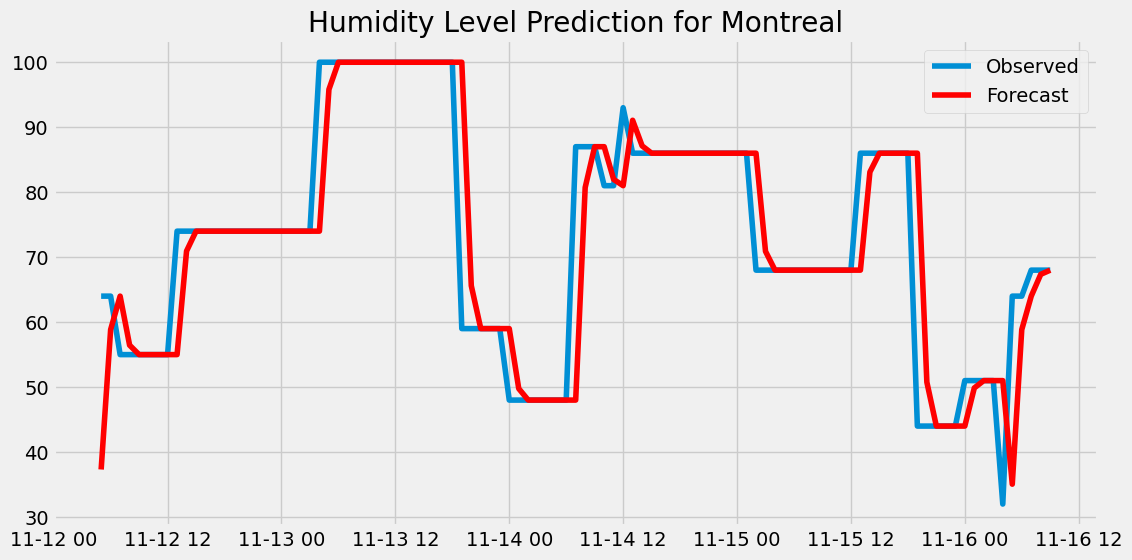

In [149]:
# Predicting humidity level of Montreal using ARIMA
montreal_humidity = humidity["Montreal"]
model = ARIMA(montreal_humidity, order=(1, 1, 0))
results = model.fit()

forecast = results.predict(start=1000, end=1100, typ='levels')

plt.figure(figsize=(12, 6))
plt.plot(montreal_humidity.index[1000:1101], montreal_humidity[1000:1101], label='Observed')
plt.plot(montreal_humidity.index[1000:1101], forecast, label='Forecast', color='red')
plt.legend()
plt.title("Humidity Level Prediction for Montreal")
plt.show()

In [151]:
observed_values = humidity["Montreal"].diff().iloc[900:1000].values
predicted_values = result.predict(start=900, end=999)

rmse = np.sqrt(mean_squared_error(observed_values, predicted_values))

print(f"The Root Mean Squared Error (RMSE) is: {rmse:.4f}")


The Root Mean Squared Error (RMSE) is: 7.0718


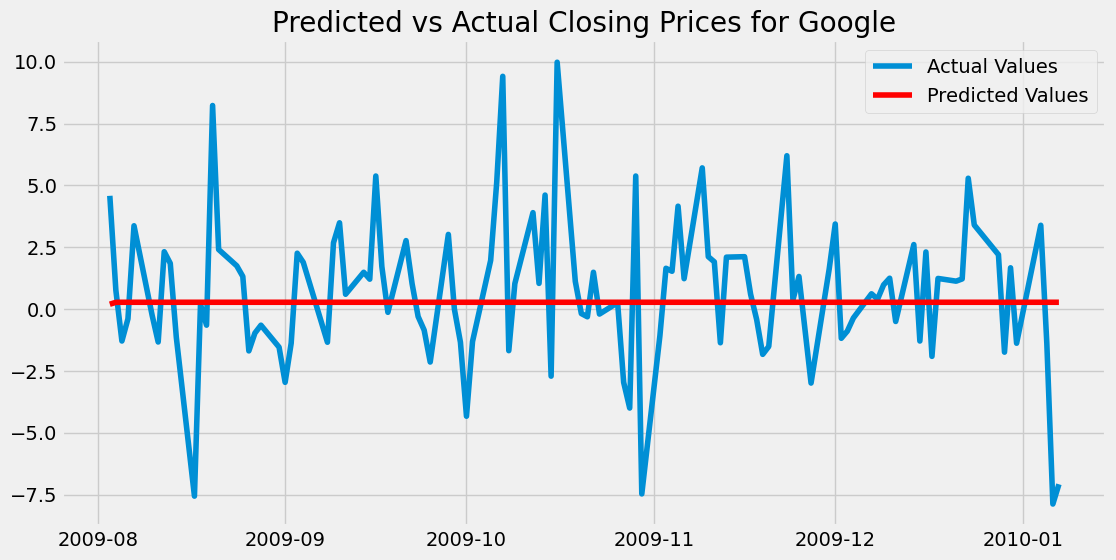

In [156]:
# Differencing the closing prices of Google
google_diff = google["Close"].diff().dropna()

# Modeling using ARIMA, which is essentially ARMA when d=0
model = ARIMA(google_diff, order=(1,0,0))
results = model.fit()

# Getting the predicted values
predicted_values = results.forecast(steps=110)  # 1010 - 900 = 110

# Plotting the predictions
plt.figure(figsize=(12, 6))
plt.plot(google_diff.index[900:1010], google_diff[900:1010], label='Actual Values')
plt.plot(google_diff.index[900:1010], predicted_values, color='red', label='Predicted Values')
plt.legend()
plt.title("Predicted vs Actual Closing Prices for Google")
plt.show()


###MA Models:

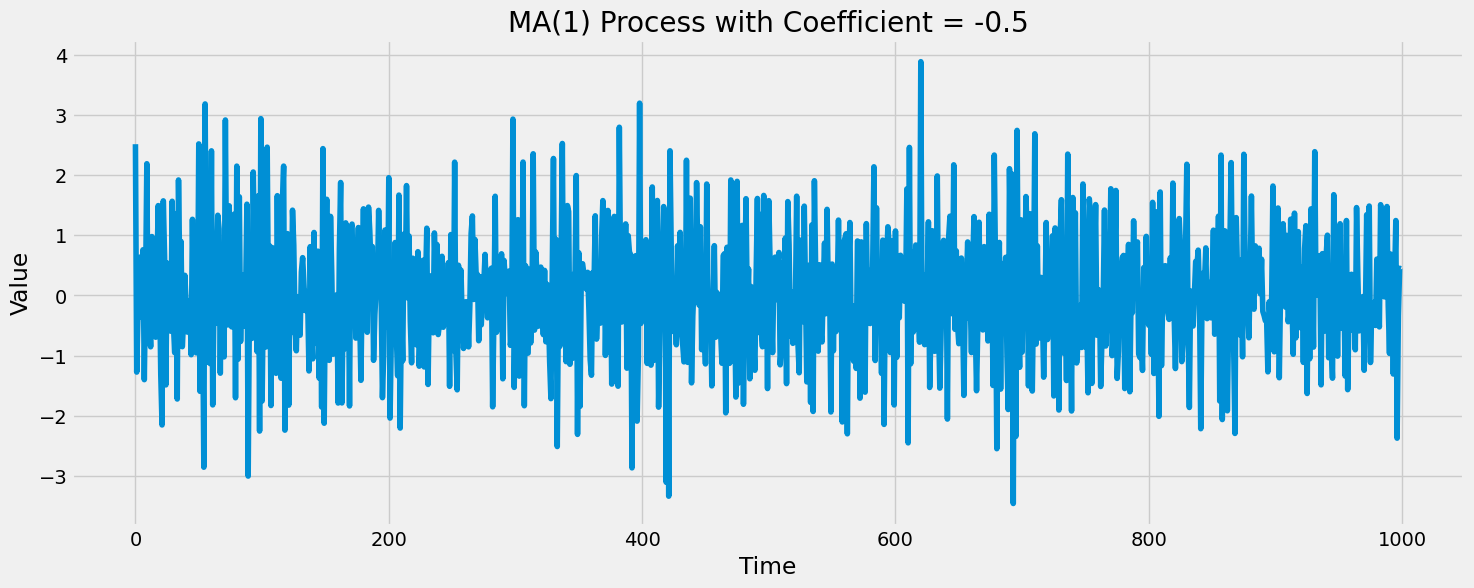

In [157]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess

def generate_ma1_process(ma_coefficient, sample_size=1000):
    """
    Generates a sample from an MA(1) process given the MA coefficient.
    Args:
    - ma_coefficient (float): The coefficient for the MA(1) process.
    - sample_size (int): The number of data points in the sample. Default is 1000.
    Returns:
    - np.array: An array of data points generated from the MA(1) process.
    """
    ar_params = [1]
    ma_params = [1, ma_coefficient]
    MA1 = ArmaProcess(ar_params, ma_params)

    return MA1.generate_sample(nsample=sample_size)

def plot_time_series(data, title):
    """
    Plots a time series data.
    Args:
    - data (np.array): The time series data.
    - title (str): The title for the plot.
    """
    plt.figure(figsize=(16, 6))
    plt.plot(data)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

# Parameters
ma_coefficient = -0.5
sample_size = 1000
title = 'MA(1) Process with Coefficient = {}'.format(ma_coefficient)

# Generate and plot
data = generate_ma1_process(ma_coefficient, sample_size)
plot_time_series(data, title)


In [158]:
# Fit an ARIMA(0,0,1) model to the first simulated data
model = ARIMA(simulations[0], order=(1, 0, 0))
result = model.fit()
print(result.summary())
print("μ={} ,ϕ={}".format(result.params[0], result.params[1]))

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1423.988
Date:                Wed, 27 Sep 2023   AIC                           2853.976
Time:                        15:18:53   BIC                           2868.700
Sample:                             0   HQIC                          2859.572
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3083      0.329      0.938      0.348      -0.336       0.952
ar.L1          0.9033      0.015     61.853      0.000       0.875       0.932
sigma2         1.0084      0.046     21.852      0.0

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                45251
Model:                 ARIMA(0, 0, 3)   Log Likelihood             -153516.982
Date:                Wed, 27 Sep 2023   AIC                         307043.965
Time:                        15:26:06   BIC                         307087.565
Sample:                             0   HQIC                        307057.686
                              - 45251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.031     -0.025      0.980      -0.061       0.060
ma.L1         -0.1621      0.003    -56.274      0.000      -0.168      -0.156
ma.L2          0.0386      0.003     12.754      0.0

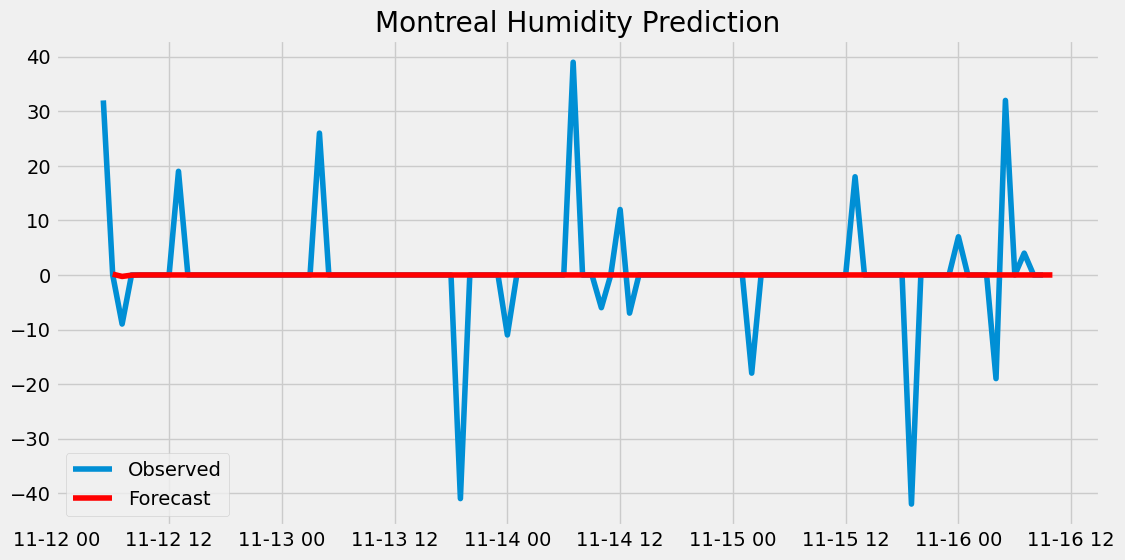

In [161]:
# Using ARIMA class but setting d=0 to get an ARMA model
model = ARIMA(humidity["Montreal"].diff().iloc[1:].values, order=(0,0,3))
result = model.fit()
print(result.summary())
print("μ={} ,θ1={} ,θ2={} ,θ3={}".format(result.params[0], result.params[1], result.params[2], result.params[3]))

# Forecast
forecasted_values = result.forecast(steps=101)  # forecast next 101 values

# Plotting the predictions
plt.figure(figsize=(12, 6))
plt.plot(humidity["Montreal"].index[1000:1101], humidity["Montreal"].diff().iloc[1000:1101].values, label='Observed')
plt.plot(humidity["Montreal"].index[1001:1102], forecasted_values, color='red', label='Forecast')
plt.title("Montreal Humidity Prediction")
plt.legend()
plt.show()

